# Introduction

This is a project on an event recommendation engine, an item-item collaborative-filtering system.


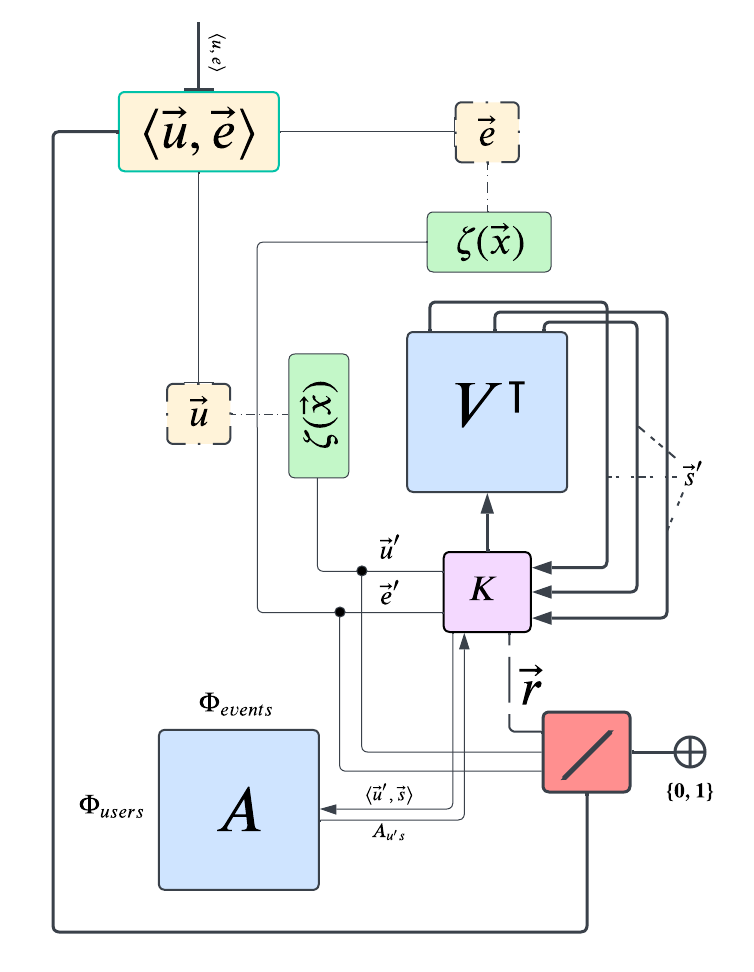

## Imports

In [ ]:
# modules
import concurrent.futures
from tqdm import tqdm
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from numpy.linalg import svd

# use supervised learning algorithms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier, IsolationForest

# base location of files
home_dir = './drive/MyDrive/event_recommender'

# metrics
sparsity            = lambda t: 1.0 - np.count_nonzero(t) / t.size
similarity          = lambda u, v, f: f(u, v)

cosine_similarity   = lambda v, u, eps=1e-8: (v @ u)/ (np.linalg.norm(v) * np.linalg.norm(u) + eps)
euclidean_distance  = lambda v, u: np.linalg.norm(v - u)
pearson_correlation = lambda v, u: np.corrcoef(v, u)[0, 1]

# indexing, labeling
lookup_id           = lambda df, id: df.loc[id]
score               = lambda values: np.mean(values)
mean_threshold      = lambda t, c: score(t) > c

lookup_user_event   = lambda user, event: [
    lookup_id(user_feature_matrix_df, user),
    lookup_id(event_feature_matrix_df, event)]


# set additional params
params = {
    "interaction_threshold": 20,  # subset of (users, events)
    "activation_threshold": 0,    # when using mean + threshold classification
    "t_k": 10,                    # top ratings to consider
    "index": {
        "similarity": pearson_correlation,
        "name": "Pearson correlation"
    },
    "k": {
        "similarity": pearson_correlation,
        "name": "Pearson correlation"
    }
}

# load datasets, variables
training_df = pd.read_csv(f'{home_dir}/raw_data/train.csv')
testing_df  = pd.read_csv(f'{home_dir}/raw_data/test.csv')
users_df    = pd.read_csv(f'{home_dir}/raw_data/users.csv', index_col=["user_id"])

user_feature_matrix_df  = pd.read_csv(f'{home_dir}/features/user_feature_matrix.csv', index_col=["user_id"])
event_feature_matrix_df = pd.read_csv(f'{home_dir}/features/event_feature_matrix.csv', index_col=["event_id"])

all_events_with_given_users_df  = pd.read_csv(f'{home_dir}/derived_data/train_test_events.csv', index_col=["event_id"])
known_users_events_df           = pd.read_csv(f'{home_dir}/derived_data/known_users_events_ratings.csv')
kue_subset_k_df                 = pd.read_csv(f'{home_dir}/derived_data/kue_subset_{params["interaction_threshold"]}.csv')

A   = kue_subset_k_df.pivot_table(
    index="user", columns="event", values="rating", aggfunc='sum').fillna(0)

u   = np.load(f'{home_dir}/features/u/u_{params["interaction_threshold"]}.npy')
s   = np.load(f'{home_dir}/features/s/s_{params["interaction_threshold"]}.npy')
vh  = np.load(f'{home_dir}/features/vh/vh_{params["interaction_threshold"]}.npy')

users  = A.index.tolist()
events = A.columns.tolist()

with open(f'{home_dir}/features/similarities_{params["interaction_threshold"]}_{params["k"]["name"]}_top_k.json') as f:
  top_k_A = [tuple(x) for x in json.load(f)]

try:
  classification_model = pickle.load(open(f'{home_dir}/models/classification/random_forest_it_{params["interaction_threshold"]}_k_{params["t_k"]}.sav', 'rb'))
except FileNotFoundError:
  classification_model = None

try:
  indexes = pd.read_csv(f'{home_dir}/models/indexes/index_it{params["interaction_threshold"]}_at{params["activation_threshold"]}_k{params["t_k"]}.csv')
  users_events_indexed = training_df.loc[training_df['event'].isin(all_events_with_given_users_df.index)]
  indexes['user'] = users_events_indexed['user'].values
  indexes['event'] = users_events_indexed['event'].values
except FileNotFoundError:
  indexes = None

# model functions
def index(matrix, user_to_index, event_to_index, f=params['index']['similarity']):
  closest_user, max_sim = None, -np.inf
  # find the closest user
  for user in matrix.index:
    sim = similarity(user_to_index, lookup_id(user_feature_matrix_df, user), f)
    if sim > max_sim:
      max_sim = sim
      closest_user = user
  if closest_user == None:
    closest_user = np.random.choice(matrix.index)

  closest_event, max_sim = None, -np.inf
  # find the closest event
  for event in matrix.columns:
    sim = similarity(event_to_index, lookup_id(event_feature_matrix_df, event), f)
    if sim > max_sim:
      max_sim = sim
      closest_event = event
  if closest_event == None:
    closest_event = np.random.choice(matrix.columns)

  return closest_user, closest_event

def top_k(k, base_col):
  cols = list(range(vh.shape[1]))

  COL_N, SIM_N = 0, 1
  # find the (col_1, col_2, s) in top_k_A where col_1 == base_col
  similarities = [(s[1], s[2]) for s in top_k_A if s[0] == base_col]
  similarities = sorted(similarities, key=lambda x: x[SIM_N], reverse=True)

  # choose top k
  return [similarities[_][COL_N] for _ in range(min(k, len(cols)))]

def classify(data, model=None):
    if model is not None:
      return model.predict(data)[0]
    else:
      return mean_threshold(data, params["activation_threshold"])

def inference(u_id, e_id, raw=False, model=classification_model, indexes=indexes):
  # get closest user_id, closest event_id
  if indexes is not None:
    try:
      phi_user_id = indexes.loc[indexes['user'] == u_id]['user_prime'].values[0]
      phi_event_id = indexes.loc[indexes['event'] == e_id]['event_prime'].values[0]
    except IndexError:
      phi_user_id, phi_event_id = index(A, *lookup_user_event(u_id, e_id))
  else:
    phi_user_id, phi_event_id = index(A, *lookup_user_event(u_id, e_id))

  # find the value in A
  raw_value = A.loc[phi_user_id, phi_event_id]

  # find the ratings for the K closest events in A
  k_closest_ratings = [A.loc[phi_user_id, events[idx]] for idx in top_k(params["t_k"], events.index(phi_event_id))]
  ratings = [raw_value] + k_closest_ratings

  # make a prediction
  if raw:
    return ratings
  else:
    if model is None:
      return classify(ratings)
    else:
      r_df = pd.DataFrame(ratings).T.add_prefix('r_')

      # create row vec for pred
      X_user_transformed        = pd.DataFrame(lookup_id(user_feature_matrix_df, u_id)).T.reset_index(drop=True)
      X_user_prime_transformed  = pd.DataFrame(lookup_id(user_feature_matrix_df, phi_user_id)).T.reset_index(drop=True)
      X_event_transformed       = pd.DataFrame(lookup_id(event_feature_matrix_df, e_id)).T.reset_index(drop=True)
      X_event_prime_transformed = pd.DataFrame(lookup_id(event_feature_matrix_df, phi_event_id)).T.reset_index(drop=True)

      features_to_add = [X_user_transformed, X_user_prime_transformed, X_event_transformed, X_event_prime_transformed]
      data_point = pd.concat([r_df] + features_to_add, axis=1).fillna(0)

      return classify(data_point, model=model)

# Define a function to be run in parallel
def infer_row(row, raw=False):
    return inference(row["user"], row["event"], raw=raw)

def make_inferences(dataset, raw=False, parallelize=False):
  results = []
  if parallelize:
    print("Making mean-centered ratings...")
    # Create a ThreadPoolExecutor to run the function in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit the predict_row function for each row in the DataFrame
        futures = [executor.submit(infer_row, row, raw) for idx, row in dataset.iterrows()]

        # Wait for all of the results to finish
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            results.append(future.result())
  else:
    for idx, row in tqdm(dataset.iterrows(), desc="inferencing...", total=dataset.shape[0]):
      results.append(infer_row(row, raw=raw))

  return results

test_first_n_percent = False
first_n_portion = 0.20

print(f"Loaded version it{params['interaction_threshold']}_k{params['t_k']}")
print(f"Using {classification_model if classification_model is not None else 'mean rating + threshold'} as predictor")

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded version it20_k10
Using RandomForestClassifier(class_weight={0: 0.04, 1: 0.96}, max_depth=12,
                       n_estimators=300) as predictor


# Task

## Dataset

The dataset is from an event recommendation challenge posted on Kaggle:

https://www.kaggle.com/c/event-recommendation-engine-challenge

Which can be downloaded by using

`% kaggle competitions download -c event-recommendation-engine-challenge`


### train.csv
An imbalanced dataset (96% 0 vs 1). Features used: `user_id`, `event_id`, `invited`.

### test.csv

Same as `train.csv`.

### users.csv
* The `birthday` column of `users` was transformed to `[before_1990, after_1990]` (based on mean of 1989, median of 1991) and imputed using a KNN with $k=50$ after applying PCA to the user feature matrix.

<AxesSubplot:xlabel='k'>

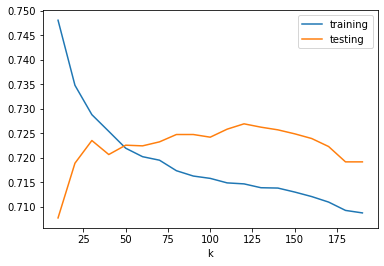

In [ ]:
knn_accuracies = {
    "k": [],
    "training": [],
    "testing": []
}

for k in range(10, 200, 10):
  knn = Pipeline([('pca', pca), ('knn', KNeighborsClassifier(n_neighbors=k))])
  knn.fit(X_train, y_train)

  knn_accuracies["k"].append(k)
  knn_accuracies["training"].append(knn.score(X_train, y_train))
  knn_accuracies["testing"].append(knn.score(X_test, y_test))

knn_accuracies_df = pd.DataFrame(knn_accuracies)
knn_accuracies_df = knn_accuracies_df.set_index("k")
knn_accuracies_df.plot()

### event_attendees.csv.gz
A map of interactions between users and events (invited, yes, maybe, no).

### events.csv.gz
* For the chosen subset of events thus far, the `country` column of `events` was imputed when `lat` and `lng` were available.

### user_friends.csv.gz
*  a map of users and their friend networks

## Predicting an outcome

The goal is given a pair $\langle user, event \rangle$: is the user invited?

The following implementation attempts to model the relationship

$$f(user, event) = invite$$

by identifying similarities through Singular Value Decomposition (SVD) and a similarity function $\text{sim}(u, v)$. Possible options are:

* cosine similarity:

$$
\text{cosim}(u, v) = \cos\left(\frac{uv}{\lVert u \rVert \lVert v \rVert}\right)
$$

* Pearson correlation:
$$
\text{corr}(u, v) = \frac{\sum (u_i - u̅)(v_i - v̅)}{\sqrt{(u_i - u̅)^2 \sum (v_i - v̅)^2}}
$$

## Components

  Let $\Phi$ be the set of users and events for which we have feature information.

  $$\Phi = \{\Phi_{users}, \Phi_{events}\}$$

  Let

  $$
  \begin{align*}
  A: \Phi_m \times \Phi_n &\to \mathbb{R}, A \in \mathbb{R^{m \times n}} &(\Phi_m, \Phi_n &\subseteq \Phi)
  \end{align*}
  $$

  be a rating matrix representing:
  * $m$ users who have interacted with > $k$ events
  * $n$ events who have been interacted with by > $k$ users

  where $k$ is called the *interaction threshold*. We will use

  $$V^{\intercal} : \ A = USV^{\intercal}$$

  to extract feature information and assist predictions.

  ## Predictions (mean + threshold)
  Let $\langle \vec u, \vec e \rangle$ be a user and event for which a prediction will be made.

  Let $y$ be the threshold rating to predict 'yes'.

  Then we have

  $$
  \begin{align*}
  f(\vec u, \vec e) &↔ g(\zeta, \vec u', \vec e', s') = \sigma(r) \\ \\
  \zeta(\vec x) &=
  \begin{cases}
    \arg \max_{u \in \Phi_{m}} \text{sim}(\vec x, u), &\vec x \in \Phi_{users} \\
    \arg \max_{e \in \Phi_{n}}  \text{sim}(\vec x, e), &\vec x \in \Phi_{events}
  \end{cases}, \ \langle \vec u', \vec e' \rangle = \langle \zeta(\vec u), \zeta(\vec e) \rangle \to O(n^2) \\ \\
  s' &= \left\{s \in \Phi_n: \left[\sum_{x \in \Phi_n \setminus \{s\}} \mathbb{1}_{\text{sim}(V^{\intercal}_s, \vec e') \ \geq \ \text{sim}(V^{\intercal}_x, \vec e')}\right] \geq \lVert \Phi_n \rVert - c\right\} \to O(n^2) + O(n \log n) \\ \\
  \vec{r} &= A_{u's}, \ \vec{r} \in \mathbb{R}^{c+1}, \ s \in \{\vec e' \cup s' \} \\ \\   
  r &= \frac{\sum_{r' \in \vec{r}} r'}{\lVert \vec{r} \rVert},
  \sigma(r) = \mathbb{1}_{r > y}
  \end{align*}
  $$

  with a time complexity of $O(n^2)$.

## Implementing classical supervised learning algorithms
We can use $\vec{r}$ as a feature for a supervised learning algorithm, for example

$$
\begin{align*}
f(T(\vec u), T(\vec e), \vec r) &= \text{invite} \\
T(\vec x) &= \langle \vec x, \vec x' \rangle
\end{align*}
$$

to improve prediction accuracy.

# Building components

## Set new parameters

In [ ]:
params = {
    "interaction_threshold": 20,  # subset of (users, events)
    "activation_threshold": 0,    # when using mean + threshold classification
    "t_k": 10,                    # top ratings to consider
    "index": {
        "similarity": pearson_correlation,
        "name": "Pearson correlation"
    },
    "k": {
        "similarity": pearson_correlation,
        "name": "Pearson correlation"
    }
}

## $A$

In [ ]:
# Look for the users who reviewed more than n events
usercount = known_users_events_df[["event","user"]].groupby("user").count()
usercount = usercount[usercount["event"] >= params["interaction_threshold"]]
usercount.shape

# Look for the events who reviewed by more than n users
eventcount = known_users_events_df[["event","user"]].groupby("event").count()
eventcount = eventcount[eventcount["user"] >= params["interaction_threshold"]]
eventcount.shape

# keep only the popular users and events
kue_subset_k_df = known_users_events_df[
    known_users_events_df["user"].isin(usercount.index)
    & known_users_events_df["event"].isin(eventcount.index)]

# save kue_subset_k
kue_subset_k_df.to_csv(f'{home_dir}/derived_data/kue_subset_{params["interaction_threshold"]}.csv')

A = kue_subset_k_df.pivot_table(
    index="user", columns="event", values="rating", aggfunc='sum').fillna(0)

A.shape

(227, 361)

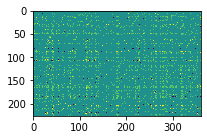

In [ ]:
fig, ax = plt.subplots(figsize=(3, 8))
ax.imshow(A, cmap='viridis', interpolation='nearest')
# plot = ax.pcolor(A)
# fig.colorbar(plot)

## $V^{\intercal}$

In [ ]:
A_values = A.values
u, s, vh = svd(A_values)

# save u, s, vh to files
np.save(f'{home_dir}/features/u/u_{params["interaction_threshold"]}.npy', u)
np.save(f'{home_dir}/features/s/s_{params["interaction_threshold"]}.npy', s)
np.save(f'{home_dir}/features/vh/vh_{params["interaction_threshold"]}.npy', vh)

vh.shape

(361, 361)

## Pre-compute similarities

### Top-k

In [ ]:
cols = list(range(vh.shape[1]))
top_k_A = []

index_similarity = params["index"]["name"]
k_similarity = params["k"]["name"]

similarities_to_compute = np.unique([index_similarity, k_similarity])

for s in similarities_to_compute:
  for col_1 in tqdm(cols, desc=f"precomputing similarites using {s}..."):
    # create (column, similarity) pairs
    COL_N, SIM_N = 0, 1

    for col_2 in cols:
        if col_1 != col_2:
          sim = similarity(vh[:,col_1], vh[:,col_2], params['k']['similarity'])
          top_k_A.append((col_1, col_2, sim))

  # save as json
  with open(f'{home_dir}/features/similarities_{params["interaction_threshold"]}_{s}_top_k.json', 'w') as f:
      json.dump(top_k_A, f)

precomputing similarites using Pearson correlation...: 100%|██████████| 361/361 [00:11<00:00, 32.06it/s]


## Classification model

### Save training set

In [ ]:
rebalance_train = False
interpolate_invited = True

In [ ]:
# need to go back and find these (we don't have feature information for them): for now, ignoring and removing
training_events_not_accounted_for = training_df.loc[~training_df['event'].isin(all_events_with_given_users_df.index)]

training_sub_df = training_df.loc[training_df['event'].isin(all_events_with_given_users_df.index)]

if rebalance_train:
  # count the number of values that are 1
  train_1_values = training_sub_df.loc[training_sub_df['invited'] == 1]
  train_1_indices = train_1_values.index.tolist()

  # count the num 0
  train_0_values = training_sub_df.loc[training_sub_df['invited'] == 0]
  train_0_indices = train_0_values.index.tolist()
  train_0_chosen_indices = []

  # random add
  for i in range(len(train_1_values)):
    chosen_index = np.random.choice(train_0_indices)
    train_0_chosen_indices.append(chosen_index)
    train_0_indices.remove(chosen_index)

  subset_indices = train_0_chosen_indices + train_1_indices

  # np.random.shuffle(subset_indices)

  tinyset = training_sub_df.loc[subset_indices]
else:
  tinyset = training_sub_df

tinyset.to_csv(f'{home_dir}/derived_data/subsample_tinyset.csv')

In [ ]:
users_events_ids = tinyset[['user', 'event']]
users_events = [tuple(lookup_user_event(x[0], x[1])) for x in list(users_events_ids.itertuples(index=False, name=None))]

In [ ]:
users_events_prime = [index(A, *user_event) for user_event in tqdm(users_events, desc="Indexing all users...")]

Indexing all users...: 100%|██████████| 14634/14634 [1:11:26<00:00,  3.41it/s]


In [ ]:
ue_prime_df = pd.DataFrame(users_events_prime, columns=['user_prime', 'event_prime'])
ue_prime_df.to_csv(f'{home_dir}/models/indexes/index_it{params["interaction_threshold"]}_at{params["activation_threshold"]}_k{params["t_k"]}.csv')

In [ ]:
predictions = make_inferences(tinyset, raw=True)
# save predictions
predictions = np.array(predictions)
np.save(f'{home_dir}/models/preds/svd_raw_preds_train_it{params["interaction_threshold"]}_at{params["activation_threshold"]}_k{params["t_k"]}_tinyset.npy', predictions)

inferencing...: 100%|██████████| 14634/14634 [03:03<00:00, 79.61it/s]


### Load training set

In [ ]:
tinyset = pd.read_csv(f'{home_dir}/derived_data/subsample_tinyset.csv')

In [ ]:
def interpolate_invite(row):
  if row['interested'] == 1:
    return 1
  elif row['not_interested'] == 1:
    return 0
  else:
    return row['invited']

In [ ]:
if interpolate_invited:
  users_events_ids = tinyset.loc[:, ['user', 'event', 'invited', 'interested', 'not_interested']]
  users_events_ids['invited'] = users_events_ids.apply(interpolate_invite, axis=1)
else:
  users_events_ids = tinyset[['user', 'event', 'invited']]

ue_prime_df = pd.read_csv(f'{home_dir}/models/indexes/index_it{params["interaction_threshold"]}_at{params["activation_threshold"]}_k{params["t_k"]}.csv', usecols=['user_prime', 'event_prime'])
predictions = np.load(f'{home_dir}/models/preds/svd_raw_preds_train_it{params["interaction_threshold"]}_at{params["activation_threshold"]}_k{params["t_k"]}_tinyset.npy')

In [ ]:
classification_raw_info = users_events_ids.copy()
classification_raw_info['user_prime'] = ue_prime_df['user_prime'].values
classification_raw_info['event_prime'] = ue_prime_df['event_prime'].values

unique_user_primes = len(classification_raw_info['user_prime'].unique())
unique_event_primes = len(classification_raw_info['event_prime'].unique())

print(f'unique user indexes used: {unique_user_primes}, unique event indexes used: {unique_event_primes}')

classification_raw_info = classification_raw_info[['user', 'event', 'invited', 'user_prime', 'event_prime']]
classification_raw_info

unique user indexes used: 182, unique event indexes used: 354


,user,event,invited,user_prime,event_prime
0,3044012,1918771225,0,3892333140,2073609284
1,3044012,1502284248,0,3892333140,843844488
2,3044012,2529072432,1,3892333140,955398943
3,3044012,3072478280,0,3892333140,3127514099
4,3044012,1390707377,0,3892333140,1532377761
...,...,...,...,...,...
14629,4293103086,2750873665,0,3892333140,843844488
14630,4293103086,4084655790,0,3892333140,1832065589
14631,4293103086,598708806,0,3892333140,843844488
14632,4293103086,604179853,0,3892333140,843844488


In [ ]:
r_df = pd.DataFrame(predictions).add_prefix('r_')

A_k_raw = pd.concat([classification_raw_info, r_df], axis=1)
A_k_raw

,user,event,invited,user_prime,event_prime,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,r_10
0,3044012,1918771225,0,3892333140,2073609284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
1,3044012,1502284248,0,3892333140,843844488,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3044012,2529072432,1,3892333140,955398943,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3044012,3072478280,0,3892333140,3127514099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
4,3044012,1390707377,0,3892333140,1532377761,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14629,4293103086,2750873665,0,3892333140,843844488,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14630,4293103086,4084655790,0,3892333140,1832065589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14631,4293103086,598708806,0,3892333140,843844488,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14632,4293103086,604179853,0,3892333140,843844488,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_raw = A_k_raw.loc[:, A_k_raw.columns != "invited"]
y_raw = A_k_raw['invited']

len(y_raw[y_raw == 1]) / len(y_raw)

0.3036080360803608

In [ ]:
X_user_transformed        = X_raw['user'].apply(lambda user: lookup_id(user_feature_matrix_df, user))
X_user_prime_transformed  = X_raw['user_prime'].apply(lambda user: lookup_id(user_feature_matrix_df, user))
X_event_transformed       = X_raw['event'].apply(lambda event: lookup_id(event_feature_matrix_df, event))
X_event_prime_transformed = X_raw['event_prime'].apply(lambda event: lookup_id(event_feature_matrix_df, event))

X_raw = pd.concat([X_raw.loc[:, X_raw.columns != "user"], X_user_transformed], axis=1)
X_raw = pd.concat([X_raw.loc[:, X_raw.columns != "user_prime"], X_user_prime_transformed], axis=1)
X_raw = pd.concat([X_raw.loc[:, X_raw.columns != "event"], X_event_transformed], axis=1)
X_raw = pd.concat([X_raw.loc[:, X_raw.columns != "event_prime"], X_event_prime_transformed], axis=1)

X_raw

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,...,is_پاکستان,is_नेपाल,is_বাংলাদেশ,is_ประเทศไทย,is_საქართველო,is_ኢትዮጵያ,is_ព្រះរាជាណាចក្រ​កម្ពុជា,is_中国,is_日本,is_대한민국
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14629,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14631,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14632,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_raw = X_raw.fillna(0)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, stratify=y_raw, test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3)

X_train_maj = X_train[y_train == 0]
X_train_min = X_train[y_train == 1]
y_test_rescaled = y_test.copy()
y_test_rescaled[y_test_rescaled == 1] = 1
y_test_rescaled[y_test_rescaled == 0] = -1

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10243, 629), (4391, 629), (10243,), (4391,))

### Test classification models

In [ ]:
models = {
    "model": [],
    "accuracy": []
}

if not interpolate_invited:
  class_weights = {0: 0.04, 1: 0.96}
else:
  class_weights = {0: 0.30, 1: 0.70}

#### Standard models

train: 0.6072439714927267
test: 0.574584377135049
              precision    recall  f1-score   support

           0       0.79      0.54      0.64      3093
           1       0.38      0.66      0.48      1298

    accuracy                           0.57      4391
   macro avg       0.58      0.60      0.56      4391
weighted avg       0.67      0.57      0.59      4391



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


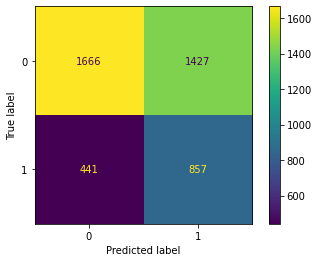

In [ ]:
# logistic regression
lr = LogisticRegression(max_iter=2000, class_weight=class_weights)

lr.fit(X_train, y_train)

acc = lr.score(X_test, y_test)
models['model'].append('Logistic Regression')
models['accuracy'].append(acc)

print(f'train: {lr.score(X_train, y_train)}')
print(f'test: {acc}')
predictions = lr.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions)).plot()

In [ ]:
# save model
pickle.dump(lr, open(f'{home_dir}/models/classification/logistic_regression_it_{params["interaction_threshold"]}_k_{params["t_k"]}.sav', 'wb'))

train: 0.6612320609196525
test: 0.5994078797540423
              precision    recall  f1-score   support

           0       0.79      0.59      0.67      3093
           1       0.39      0.63      0.48      1298

    accuracy                           0.60      4391
   macro avg       0.59      0.61      0.58      4391
weighted avg       0.67      0.60      0.62      4391



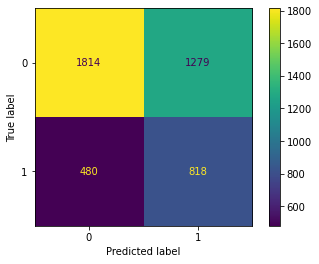

In [ ]:
# decision tree
dt = tree.DecisionTreeClassifier(max_depth=8, class_weight=class_weights)

dt.fit(X_train, y_train)

acc = dt.score(X_test, y_test)

models['model'].append("Decision Tree")
models['accuracy'].append(acc)

print(f'train: {dt.score(X_train, y_train)}')
print(f'test: {acc}')
predictions = dt.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, dt.predict(X_test))).plot()

In [ ]:
pickle.dump(dt, open(f'{home_dir}/models/classification/decision_tree_it_{params["interaction_threshold"]}_k_{params["t_k"]}.sav', 'wb'))

In [ ]:
# random forest
from sklearn.model_selection import GridSearchCV

# Define a custom scoring function that computes the F-score for the minority class
def minority_f1_score(y_true, y_pred):
    minority_class = 1 # assuming the minority class is labeled as 1
    return f1_score(y_true, y_pred, pos_label=minority_class)

rf = RandomForestClassifier(class_weight=class_weights)

param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [7, 12, 16, 20, 24]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=make_scorer(minority_f1_score), verbose=3)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_estimator_)
print("Best f1 score:", grid_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .....max_depth=7, n_estimators=100;, score=0.467 total time=   1.6s
[CV 2/5] END .....max_depth=7, n_estimators=100;, score=0.468 total time=   1.6s
[CV 3/5] END .....max_depth=7, n_estimators=100;, score=0.468 total time=   1.1s
[CV 4/5] END .....max_depth=7, n_estimators=100;, score=0.468 total time=   1.0s
[CV 5/5] END .....max_depth=7, n_estimators=100;, score=0.468 total time=   1.0s
[CV 1/5] END .....max_depth=7, n_estimators=300;, score=0.467 total time=   2.9s
[CV 2/5] END .....max_depth=7, n_estimators=300;, score=0.469 total time=   4.0s
[CV 3/5] END .....max_depth=7, n_estimators=300;, score=0.468 total time=   4.3s
[CV 4/5] END .....max_depth=7, n_estimators=300;, score=0.467 total time=   2.9s
[CV 5/5] END .....max_depth=7, n_estimators=300;, score=0.468 total time=   2.9s
[CV 1/5] END .....max_depth=7, n_estimators=500;, score=0.467 total time=   7.2s
[CV 2/5] END .....max_depth=7, n_estimators=500

KeyboardInterrupt: ignored

train: 0.7542712096065606
test: 0.6374402186290139
              precision    recall  f1-score   support

           0       0.79      0.66      0.72      3093
           1       0.42      0.58      0.49      1298

    accuracy                           0.64      4391
   macro avg       0.60      0.62      0.60      4391
weighted avg       0.68      0.64      0.65      4391



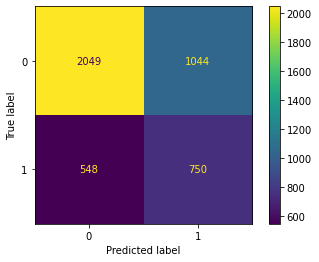

In [ ]:
rf = RandomForestClassifier(n_estimators=300, max_depth=12, class_weight=class_weights)

rf.fit(X_train, y_train)

acc = rf.score(X_test, y_test)

models['model'].append('Random Forest')
models['accuracy'].append(acc)

print(f'train: {rf.score(X_train, y_train)}')
print(f'test: {acc}')
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, rf.predict(X_test))).plot()

In [ ]:
# save model
pickle.dump(rf, open(f'{home_dir}/models/classification/random_forest_it_{params["interaction_threshold"]}_k_{params["t_k"]}_alt.sav', 'wb'))

In [ ]:
# SVM
if not interpolate_invited:
  svc = svm.SVC(class_weight=class_weights)
else:
  svc = svm.SVC()

svc.fit(X_train, y_train)

train_preds = svc.predict(X_train)
test_preds = svc.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

models['model'].append('SVM')
models['accuracy'].append(acc)

print(f'train: {train_acc}')
print(f'test: {test_acc}')

print((classification_report(y_test, test_preds)))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_preds)).plot()

In [ ]:
pickle.dump(svc, open(f'{home_dir}/models/classification/svm_it_{params["interaction_threshold"]}_k_{params["t_k"]}.sav', 'wb'))

In [ ]:
# mlp
clf = MLPClassifier(hidden_layer_sizes=(100,100))
clf.fit(X_train, y_train)

acc = clf.score(X_test, y_test)

models['model'].append('MLP')
models['accuracy'].append(acc)

print(f'train: {clf.score(X_train, y_train)}')
print(f'test: {acc}')
predictions = clf.predict(X_test)
print((classification_report(y_test, predictions)))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, clf.predict(X_test))).plot()

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<AxesSubplot:>

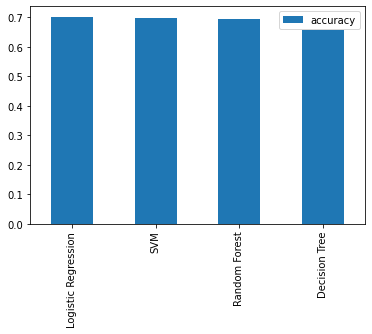

In [ ]:
pd.DataFrame(models, index=models['model']).sort_values('accuracy', ascending=False).plot(kind='bar')

#### One-class specific methods

In [ ]:
model = svm.OneClassSVM(gamma='scale', nu=class_weights[1])
model.fit(X_train_maj)
yhat = model.predict(X_test)
score = f1_score(y_test_rescaled, yhat, pos_label=-1)
print('F1 Score: %.3f' % score)

F1 Score: 0.960


              precision    recall  f1-score   support

          -1       0.96      0.96      0.96      4203
           1       0.03      0.02      0.02       188

    accuracy                           0.92      4391
   macro avg       0.49      0.49      0.49      4391
weighted avg       0.92      0.92      0.92      4391



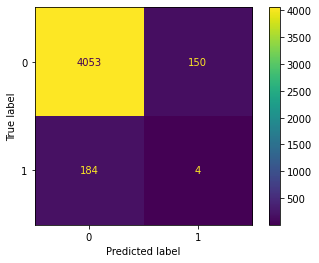

In [ ]:
print((classification_report(y_test_rescaled, yhat)))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_rescaled, yhat)).plot()

In [ ]:
model = IsolationForest(contamination=class_weights[0])
model.fit(X_train_min)
yhat = model.predict(X_test)
score = f1_score(y_test_rescaled, yhat, pos_label=-1)
print('F1 Score: %.3f' % score)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


F1 Score: 0.072


              precision    recall  f1-score   support

          -1       0.94      0.04      0.07      4203
           1       0.04      0.95      0.08       188

    accuracy                           0.08      4391
   macro avg       0.49      0.49      0.08      4391
weighted avg       0.90      0.08      0.07      4391



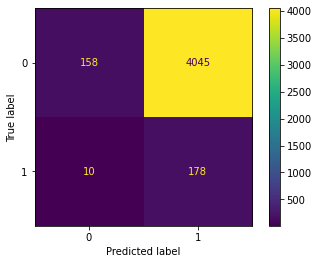

In [ ]:
print((classification_report(y_test_rescaled, yhat)))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_rescaled, yhat)).plot()

# Model

## Information

In [ ]:
print(f"size of A: ({A.shape[0]} users, {A.shape[1]} events) --> {100*sparsity(A):.2f}% sparse")

size of A: (227 users, 361 events) --> 89.70% sparse


## Predictions

In [ ]:
test_examples = [(1028672804, 2816742760)]

In [ ]:
user_id  = np.random.choice(user_feature_matrix_df.index)
event_id = np.random.choice(event_feature_matrix_df.index)

print(f"(user: {user_id}, event: {event_id}) --> {inference(user_id, event_id, raw=True)}")

(user: 3418082559, event: 789146264) --> [5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
user_prime_id, event_prime_id = index(A, *lookup_user_event(user_id, event_id))
user_prime_id, event_prime_id

(3676032097, 1151525474)

In [ ]:
# build row vec
predictions = inference(user_id, event_id, raw=True)
pd.DataFrame(predictions).T.add_prefix('k_')

,k_0,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0


In [ ]:
r_df = pd.DataFrame(predictions).T.add_prefix('r_')

X_user_transformed        = pd.DataFrame(lookup_id(user_feature_matrix_df, user_id)).T.reset_index(drop=True)
X_user_prime_transformed  = pd.DataFrame(lookup_id(user_feature_matrix_df, user_prime_id)).T.reset_index(drop=True)
X_event_transformed       = pd.DataFrame(lookup_id(event_feature_matrix_df, event_id)).T.reset_index(drop=True)
X_event_prime_transformed = pd.DataFrame(lookup_id(event_feature_matrix_df, event_prime_id)).T.reset_index(drop=True)

features_to_add = [X_user_transformed, X_user_prime_transformed, X_event_transformed, X_event_prime_transformed]
row_vec = pd.concat([r_df] + features_to_add, axis=1).fillna(0)
row_vec

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,...,is_پاکستان,is_नेपाल,is_বাংলাদেশ,is_ประเทศไทย,is_საქართველო,is_ኢትዮጵያ,is_ព្រះរាជាណាចក្រ​កម្ពុជា,is_中国,is_日本,is_대한민국
0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
inference(user_id, event_id)

0

In [ ]:
pd.DataFrame(users_df.loc[user_id]).T

,locale,birthyear,gender,joinedAt,location,timezone
3418082559,ar_AR,1988,male,2012-11-10T17:34:06.899Z,Jeddah 14,180.0


In [ ]:
pd.DataFrame(all_events_with_given_users_df.loc[event_id]).T

,Unnamed: 0,user_id,start_time,city,state,zip,country,lat,lng,c_1,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
789146264,8914,2398414718,2012-10-20T14:30:00.003Z,NaN,NaN,NaN,NaN,NaN,NaN,17,...,0,0,2,0,0,0,0,0,0,133


# Results

## Test training, testing data

In [ ]:
# train on resampled data
rebalance_train = False
rebalance_test  = False

### Training data

#### Load dataset

 4.96% are not accounted for
accuracy guessing 0: 0.957222905562389


<AxesSubplot:>

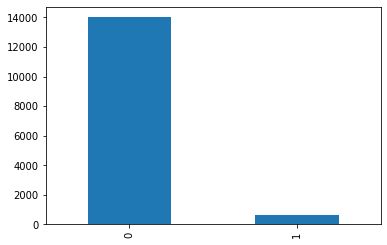

In [ ]:
# need to go back and find these (we don't have feature information for them): for now, ignoring and removing
training_events_not_accounted_for = training_df.loc[~training_df['event'].isin(all_events_with_given_users_df.index)]
print(f"{100 * len(training_events_not_accounted_for) / len(training_df): .2f}% are not accounted for")

training_sub_df = training_df.loc[training_df['event'].isin(all_events_with_given_users_df.index)]

# just guessing 0 -- effectively measuring the sparsity
print(f"accuracy guessing 0: {accuracy_score(training_sub_df['invited'].values, np.zeros_like(training_sub_df['invited'].values))}")
training_sub_df['invited'].value_counts().plot(kind='bar')

In [ ]:
# rebalance and test
if rebalance_train:
  # count the number of values that are 1
  train_1_values = training_sub_df.loc[training_sub_df['invited'] == 1]
  train_1_indices = train_1_values.index.tolist()

  train_0_values = training_sub_df.loc[training_sub_df['invited'] == 0]
  train_0_indices = train_0_values.index.tolist()
  train_0_chosen_indices = []

  for i in range(len(train_1_values)):
    chosen_index = np.random.choice(train_0_indices)
    train_0_chosen_indices.append(chosen_index)
    train_0_indices.remove(chosen_index)

  if test_first_n_percent:
    np.random.shuffle(train_0_chosen_indices)
    np.random.shuffle(train_1_indices)

    train_0_chosen_indices = train_0_chosen_indices[:int(len(train_0_chosen_indices) * first_n_portion)]
    train_1_indices = train_1_indices[:int(len(train_1_indices) * first_n_portion)]

  subset_indices = train_0_chosen_indices + train_1_indices

  np.random.shuffle(subset_indices)

  tinyset = training_sub_df.loc[subset_indices]
  tinyset['invited'].value_counts().plot(kind='bar')
  print(f"accuracy guessing 0: {accuracy_score(tinyset['invited'].values, np.zeros_like(tinyset['invited'].values))}")

else:
  tinyset = training_sub_df

print(f"number to test: {len(tinyset)}")

number to test: 14634


#### Make predictions

In [ ]:
predictions = make_inferences(tinyset)

inferencing...: 100%|██████████| 14634/14634 [14:54<00:00, 16.36it/s]


In [ ]:
# save predictions
with open(f'{home_dir}/models/preds/svd_preds_train_it{params["interaction_threshold"]}_at{params["activation_threshold"]}_k{params["t_k"]}_tinyset.csv', 'w') as fp:
  for pred in predictions:
    fp.write(str(pred) + '\n')

In [ ]:
correct = [1 if i == j else 0 for i, j in zip(predictions, tinyset['invited'].values)]
accuracy = sum(correct) / len(predictions)
print(f"accuracy: {accuracy:.2f}")

accuracy: 0.88


#### Load predictions

In [ ]:
preds_df = pd.read_csv(f'{home_dir}/models/preds/svd_preds_train_it{params["interaction_threshold"]}_at{params["activation_threshold"]}_k{params["t_k"]}_tinyset.csv', header=None)
predictions = [1 if _ else 0 for _ in preds_df.values]

accuracy: 0.8805521388547218
false positive rate: 0.8851370645345517
false negative rate: 0.2220447284345048


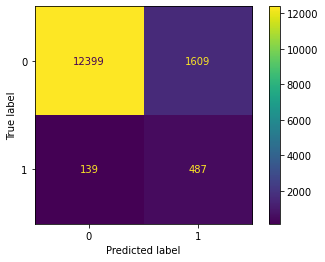

In [ ]:
y_test = tinyset['invited'].values
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = cm.ravel()
print(f"accuracy: {accuracy_score(y_test, predictions)}")
print(f"false positive rate: {1 - fp / (fp + tn)}")
print(f"false negative rate: {fn / (fn + tp)}")
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93     14008
           1       0.23      0.78      0.36       626

    accuracy                           0.88     14634
   macro avg       0.61      0.83      0.65     14634
weighted avg       0.96      0.88      0.91     14634



### Testing data

#### Load dataset

In [ ]:
# need to go back and find these (we don't have feature information for them): for now, ignoring and removing
testing_events_not_accounted_for = testing_df.loc[~testing_df['event'].isin(all_events_with_given_users_df.index)]
print(f"{100 * len(testing_events_not_accounted_for) / len(testing_df): .2f}% are not accounted for")

testing_sub_df = testing_df.loc[testing_df['event'].isin(all_events_with_given_users_df.index)]

 50.30% are not accounted for


accuracy guessing 0: 0.967374213836478


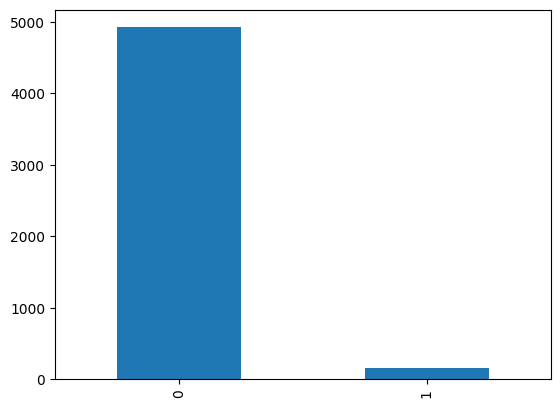

In [ ]:
testing_sub_df['invited'].value_counts().plot(kind='bar')
# just guessing 0 -- effectively measuring the sparsity
print(f"accuracy guessing 0: {accuracy_score(testing_sub_df['invited'].values, np.zeros_like(testing_sub_df['invited'].values))}")

In [ ]:
# rebalance and test
if rebalance_test:
  # count the number of values that are 1
  train_1_values = testing_sub_df.loc[testing_sub_df['invited'] == 1]
  train_1_indices = train_1_values.index.tolist()

  train_0_values = testing_sub_df.loc[testing_sub_df['invited'] == 0]
  train_0_indices = train_0_values.index.tolist()
  train_0_chosen_indices = []

  for i in range(len(train_1_values)):
    chosen_index = np.random.choice(train_0_indices)
    train_0_chosen_indices.append(chosen_index)
    train_0_indices.remove(chosen_index)

  subset_indices = train_0_chosen_indices + train_1_indices
  np.random.shuffle(subset_indices)

  tinyset = testing_sub_df.loc[subset_indices]
  tinyset['invited'].value_counts().plot(kind='bar')
  print(f"accuracy guessing 0: {accuracy_score(tinyset['invited'].values, np.zeros_like(tinyset['invited'].values))}")
else:
  tinyset = testing_sub_df

print(f"number to test: {len(tinyset)}")

number to test: 5088


#### Make predictions

In [ ]:
predictions = make_inferences(tinyset)

inferencing...: 100%|██████████| 5088/5088 [26:16<00:00,  3.23it/s]


In [ ]:
# save predictions
with open(f'{home_dir}/models/svd_preds_test_it{params["interaction_threshold"]}_at{params["activation_threshold"]}_k{params["t_k"]}_tinyset.csv', 'w') as fp:
  for pred in predictions:
    fp.write(str(pred) + '\n')

In [ ]:
correct = [1 if i == j else 0 for i, j in zip(predictions, tinyset['invited'].values)]
accuracy = sum(correct) / len(predictions)
print(f"accuracy: {accuracy:.2f}")

accuracy: 0.93


#### Load predictions

In [ ]:
preds_df = pd.read_csv(f'{home_dir}/models/svd_preds_test_it{params["interaction_threshold"]}_at{params["activation_threshold"]}_k{params["t_k"]}_tinyset.csv', header=None)
predictions = [1 if _ else 0 for _ in preds_df.values]

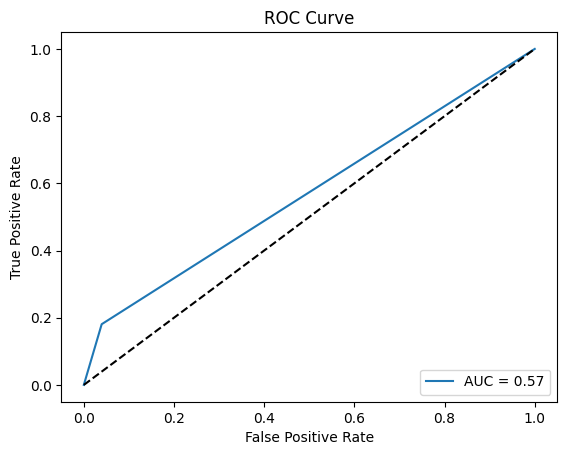

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(testing_sub_df['invited'], predictions)

# Compute AUC
auc = roc_auc_score(testing_sub_df['invited'], predictions)

# Plot ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal dashed line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

accuracy: 0.9349449685534591
false positive rate: 0.039618041446566436
false negative rate: 0.8192771084337349


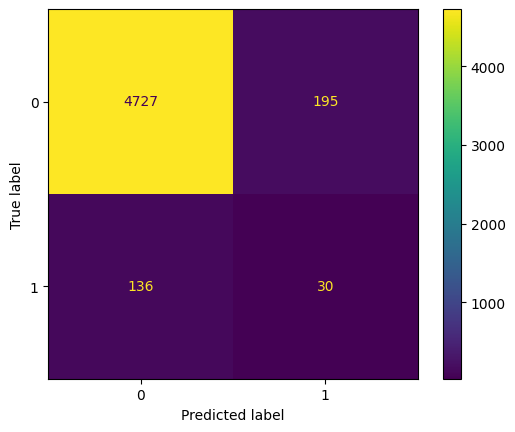

In [ ]:
y_test = tinyset['invited'].values
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = cm.ravel()
print(f"accuracy: {accuracy_score(y_test, predictions)}")
print(f"false positive rate: {fp / (fp + tn)}")
print(f"false negative rate: {fn / (fn + tp)}")
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4922
           1       0.13      0.18      0.15       166

    accuracy                           0.93      5088
   macro avg       0.55      0.57      0.56      5088
weighted avg       0.94      0.93      0.94      5088



In [ ]:
correct_matches = []

for i in range(len(correct)):
  if correct[i] and tinyset.iloc[i]['invited'] == 1:
    correct_matches.append({
        'user': tinyset.iloc[i]['user'],
        'event': tinyset.iloc[i]['event']
    })

for pair in correct_matches:
  print(f"{users_df.loc[pair['user']]['location']} -> {all_events_with_given_users_df.loc[pair['event']][['lat', 'lng']].values}")

Toronto  Ontario -> [44.389 -79.692]
Toronto  Ontario -> [43.665 -79.41]
Toronto  Ontario -> [43.649 -79.421]
Phnom Penh  11 -> [11.569 104.914]
Los Angeles  California -> [nan nan]
Los Angeles  California -> [nan nan]
San Francisco  California -> [37.787 -122.41]
San Francisco  California -> [37.787 -122.41]
nan -> [43.846 -79.381]
nan -> [43.703 -79.637]
Toronto  Ontario -> [43.646 -79.42]
San Francisco  California -> [37.787 -122.41]
San Francisco  California -> [37.787 -122.41]
Santo Domingo  Dominican Republic -> [18.489 -69.988]
Los Angeles  California -> [34.021 -118.286]
Los Angeles  California -> [nan nan]
Toronto  Ontario -> [43.789 -79.532]
Fontana  California -> [33.996 -118.199]
Toronto  Ontario -> [43.667 -79.385]
Los Angeles  California -> [33.961 -118.353]
Toronto  Ontario -> [45.427 -75.689]
Toronto  Ontario -> [45.427 -75.689]
Wolcott  Connecticut -> [41.312 -72.93]
Santo Domingo  05 -> [18.489 -69.988]
nan -> [43.646 -79.391]
nan -> [43.646 -79.391]
nan -> [43.646 -7

# TODO

In [ ]:
# need to go find these
training_df.loc[~training_df['event'].isin(all_events_with_given_users_df.index)]

,user,event,invited,timestamp,interested,not_interested
6,4236494,2352676247,0,2012-10-30 01:48:25.617000+00:00,0,0
21,7547671,2573061069,0,2012-12-06 13:40:49.700000+00:00,0,0
34,13301498,97217712,0,2012-10-24 01:00:14.160000+00:00,0,0
81,22840021,2985774237,0,2012-10-24 20:40:33.908000+00:00,0,0
83,23150045,735593165,0,2012-10-07 01:01:06.034000+00:00,1,0
...,...,...,...,...,...,...
15188,4239378941,3338163812,0,2012-07-07 19:31:01.969000+00:00,0,0
15327,4272342830,952519340,0,2012-10-31 20:54:06.656000+00:00,1,0
15347,4278168842,1112764536,0,2012-11-05 12:37:32.805000+00:00,0,0
15373,4286635694,281688155,0,2012-12-04 10:37:39.033000+00:00,0,0


retrain except edit the invited column such that:
```
if interested = 1: invited = 1
if not_interested = 0: invited = 0
else invited = invited
```

# Research

* add weights to k-most similar items, find weights through gradient descent

There are a few potential areas for improvement:

Selection of users and events: The approach assumes that only users and events that have interacted with at least $c$ other users/events are included in the dataset. This may not be sufficient to capture the full range of user preferences and event characteristics. It may be useful to also consider including a random sample of users and events in the dataset to ensure a more diverse set of data.

**Have not explored**

Selection of $c$: The value of $c$ used to select users and events may significantly impact the quality of the recommendations. A larger value of $c$ may provide a more accurate representation of user preferences and event characteristics, but may also result in a smaller dataset. Conversely, a smaller value of $c$ may provide a larger dataset but may result in less accurate recommendations. It may be useful to experiment with different values of $c$ to find the optimal value for the dataset.

**Result: 20 > 10 > 30 > 5**

Similarity search: The approach uses cosine similarity to find the most similar user and event vectors. While this is a common approach, it may not be the best choice for all datasets. Other similarity measures, such as Euclidean distance or Pearson correlation, may provide better results depending on the dataset.

**Result: Pearson > Cosine > Euclidean**

Handling missing values: The approach does not account for missing values in the review matrix. It may be useful to explore different methods for handling missing values, such as imputation or regularization techniques, to improve the accuracy of the recommendations.

**Have not explored, A is very sparse**

Evaluation of performance: It is important to evaluate the performance of the recommender system to ensure it is providing accurate recommendations. This can be done using techniques such as cross-validation or calculating metrics such as mean absolute error or root mean squared error. It is important to continuously evaluate and refine the system to improve its performance over time.

**Decision: use f-score of minority class**

--ChatGPT

Ways to improve the binary prediction:

Tuning the threshold: The threshold used in the step function can have a big impact on the performance of the binary prediction. It is important to choose a threshold that balances the trade-off between precision and recall. You could try tuning the threshold using a validation set or cross-validation to find the best trade-off for your particular dataset.

**Result: minimal improvement**

Weighting the ratings: In the mean rating calculation, you could try weighting the ratings from the most similar events more heavily than those from less similar events. This could help to give more weight to events that are more similar to the user's preferences and improve the accuracy of the prediction.

**Decision: not worth exploring right now**

Using different similarity measures: The choice of similarity measure used to find the most similar events can also have a big impact on the performance of the binary prediction. You could try using different similarity measures, such as cosine similarity or Pearson correlation, to see if they lead to better performance on your dataset.

**Result: Pearson > cosine > euclidean**

Using more sophisticated machine learning algorithms: While the mean rating + threshold step function approach is a simple and interpretable method, it may not be the most powerful or flexible method for making recommendations. You could explore more sophisticated machine learning algorithms, such as logistic regression or decision trees, to see if they provide better accuracy and flexibility in your predictions.

**Result: random forest greatly improves performance**

--ChatGPT

I finally decided to look up what the process I've settled on is.
It's called [item-item collaborative filtering](https://en.wikipedia.org/wiki/Item-item_collaborative_filtering#:~:text=Item%2Ditem%20collaborative%20filtering%2C%20or,by%20Amazon.com%20in%201998.).

Amazon actually invented it back in 1998!

Some takeaways:
First, the system executes a model-building stage by finding the similarity between all pairs of items.
* I should precompute this beforehand and save the overhead.

Second, the system executes a recommendation stage. It uses the most similar items to a user's already-rated items to generate a list of recommendations. Usually this calculation is a weighted sum or linear regression.
* I need to test the model that performed similarly $(0.523, 0.521)$ with a threshold of 0.08 -- this means that if more than 1/11 are invited (on average) we return true.
* I think the dataset is too sparse for the weighted sum to work. I will explore the usual suspects with the ratings straight from the model.

Upon experimentation the system makes weird predictions sometimes --

A user and event in a different country will trigger a yes sometimes.
Not that isn't possible, just highly unlikely.

I think implementing a classification model on top of this rating system will help. Given $(u, u', e, e', r)$, what is the prediction?



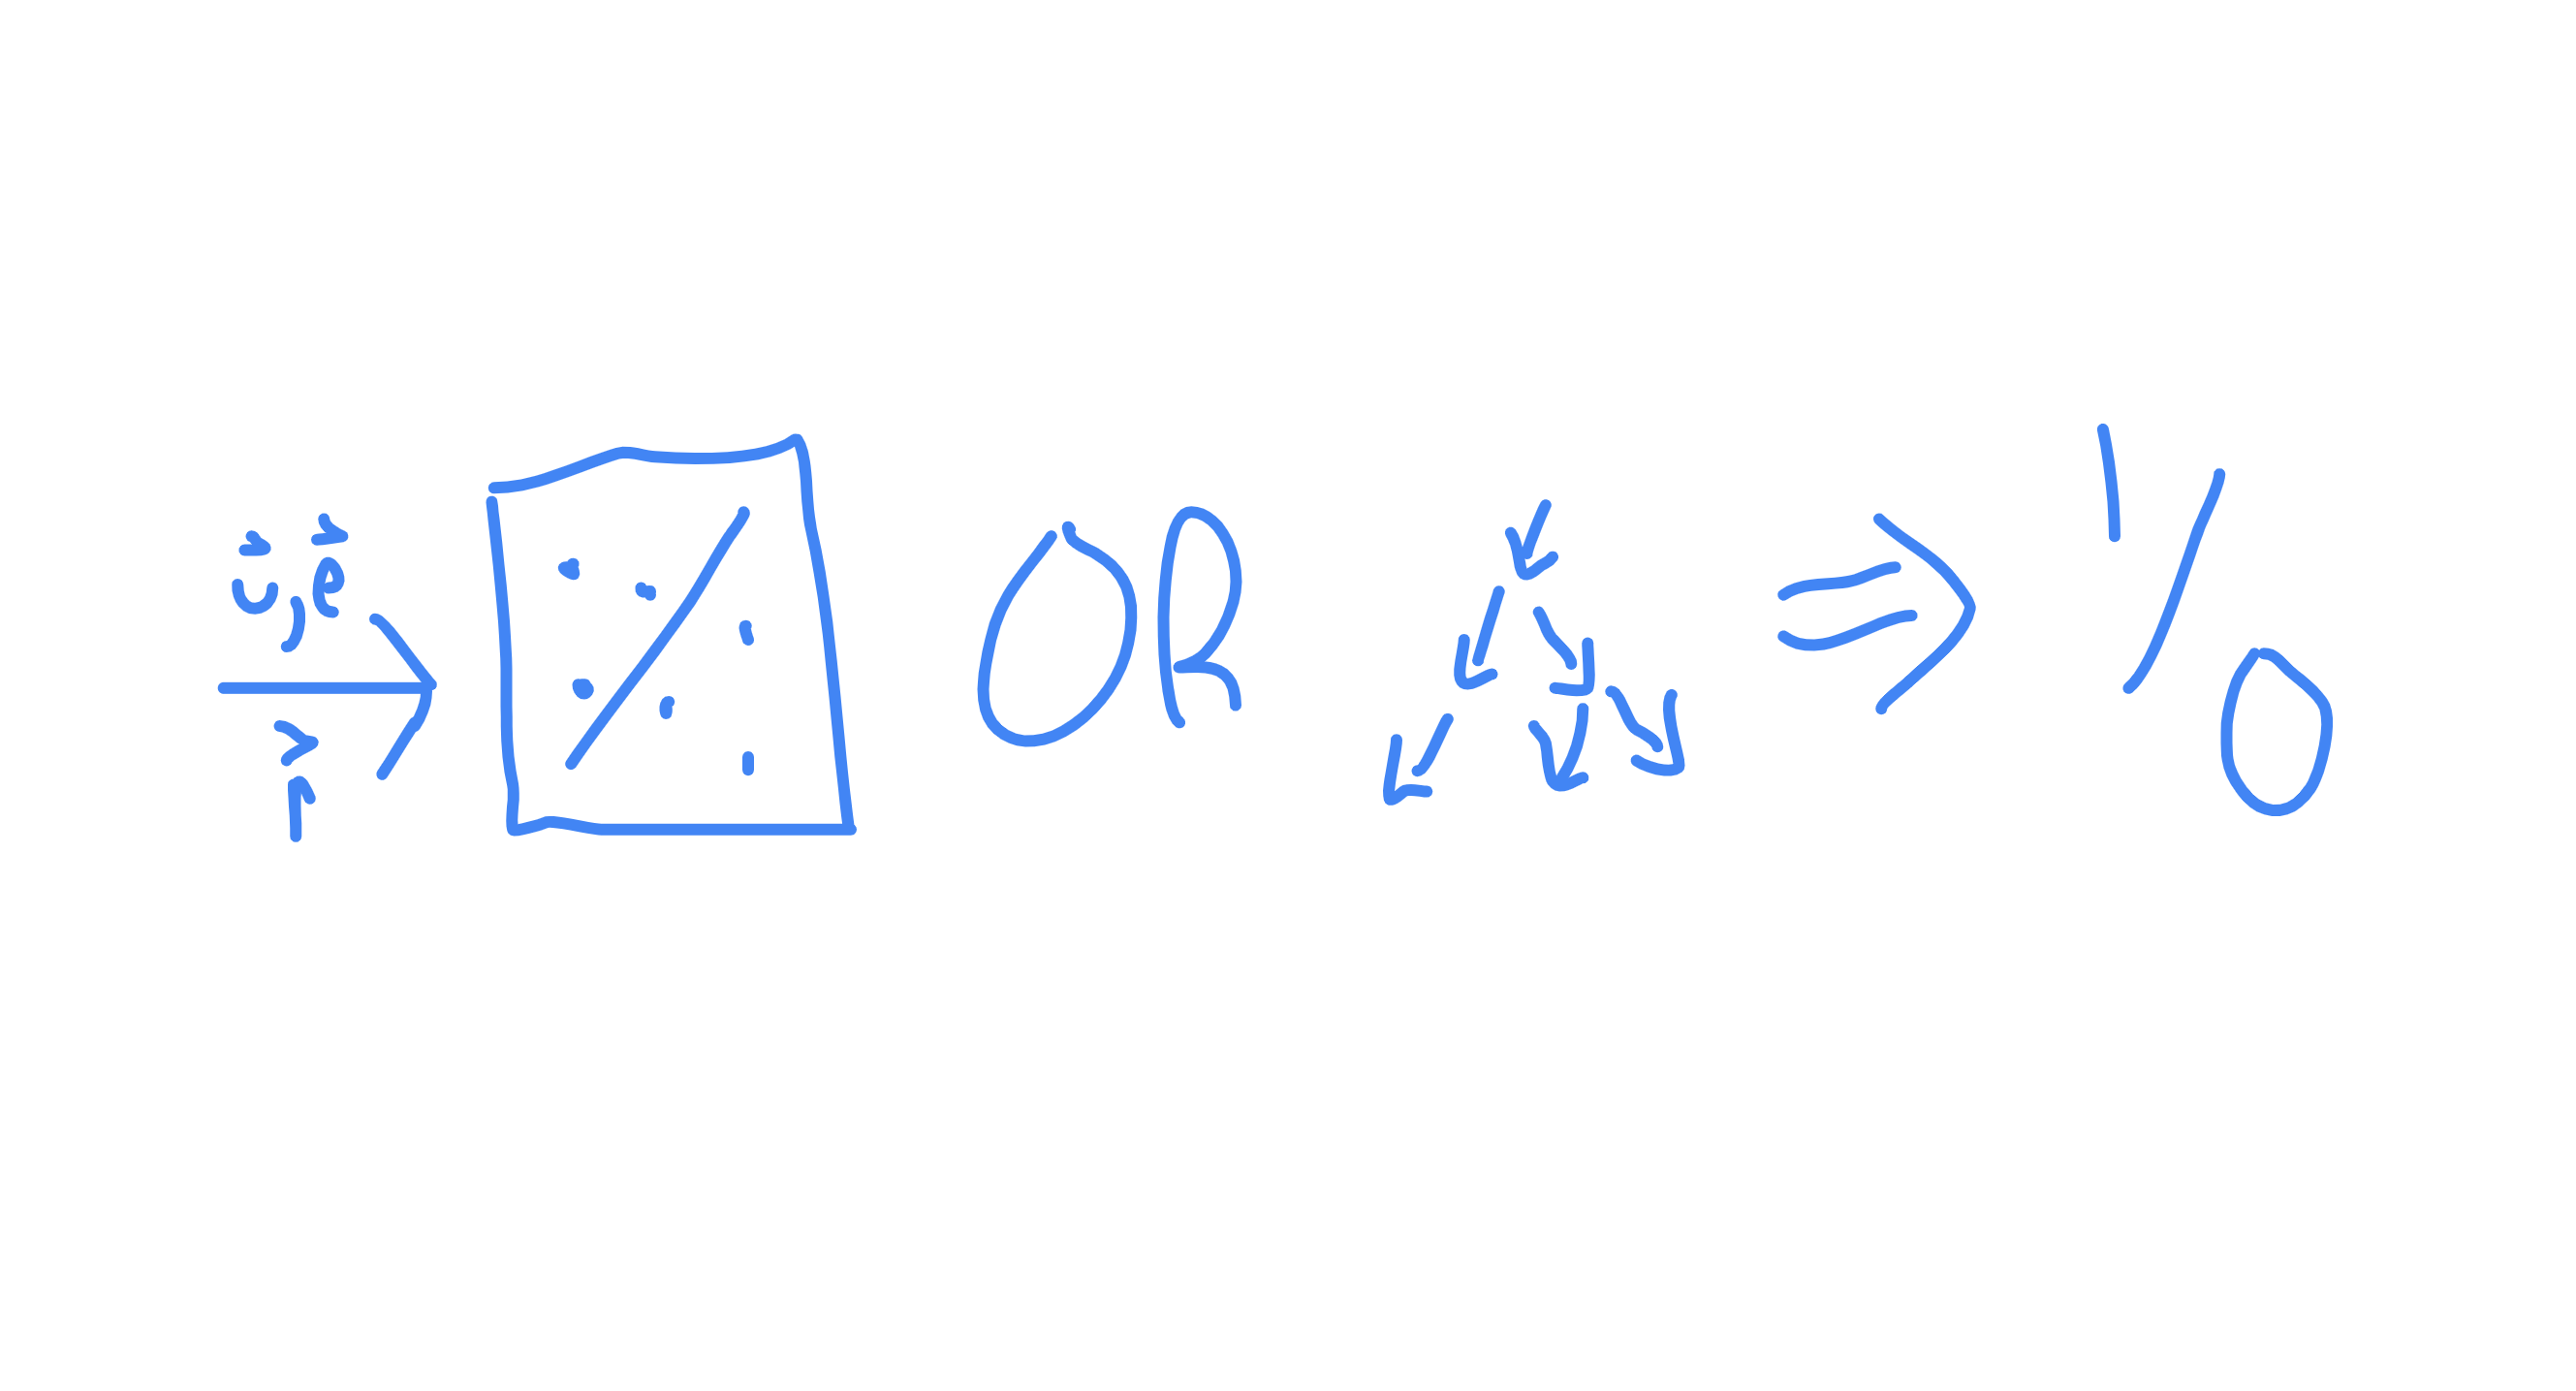